# Trees - Modelling

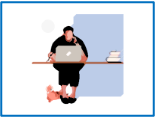

## PROBLEM: With given dataset, predict the probability of the payment within 90 days!

This is a small sample of data (both in terms of observations and available variables) that is actually used for training our models in *****. All the IDs are replaced, and all datapoints have a slight noise added to them to avoid any chance of identification. Data is stored as a small SQLite database stored in attached `session_11.db` file. There are two tables - `dataset` and `metadata`. The data sample spans 1 year and 30k observations.

### Some background information on the data

The intended target for prediction is `ct090`, `case_id` is the unique identifier, `keydate` is the point in time when some event has happened in the lifecycle of a case, and also a date relative to which all of the backward looking variables and forward looking targets are calculated. In this case, it's a general purpose propensity to pay model, which means that it is a freshly registered case, where all the relevant data has been gathered and verified. In other words, `keydate` is set a few days after registration, and target `ct090` is checking for outcome in 90 days (`ap090` is a similar regression target), while all the rest of the data is only looking backwards!

Metadata gives some basic description of variables. The general naming convention is based on prefixes that define aggregation levels - `cXXXX` looking at the data of this case only, `dXXXX` looking at other cases of same debtor, `bXXXX` looking at all cases of the debtor, `aXXXX` looking at all the cases on the same address. This is not very relevant for this particular task, but gives some idea of our data setup here in ******! Note that this data selection has quite a few variables with the `dXXXX` prefix, which means that this selection is specifically looking at debtors that we already had worked with before, therefore, variable selection is much broader and models are generally better. 

One more tip on interpretation of missing values: if variable is bound by time window, e.g. `d2112 NumberOfCustomerPaymentsInLast12Months`, the `NA` value implies that there never have been any values, while `0` would mean that have been no values within bounding period (in this case 12 months). In other words, `0` and `NA` have different interpretation. It may or may not be relevant, depending on the choice of the modelling approach. 

### Some tips on the task

There is no end to seeking the perfection, and countless ways to approach this task. However, try not to approach this like a competition to crank out the highest possible accuracy metrics. What matters is the sequence and thought process - show this in illustrations and comments! Even if certain things might take too long to implement in a code, but you have a good idea where to go with this - write down your ideas! This is what matters.

Good luck!

In [95]:
! pip install pandas


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Solution

### First look at the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [3]:
# Load data
conn = sqlite3.connect('session_11_db.db')
df = pd.read_sql_query('SELECT * FROM dataset', conn)

# Get the list of tables in the database
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)
print(tables)

# check the shape of data
print('Data shape:', df.shape)

       name
0   dataset
1  metadata
Data shape: (30000, 19)


In [4]:
print(df)

       case_id                keydate  ct090  ap090   c0001  c0039 c0044   
0            1  2017-08-12 00:00:00.0    0.0    0.0  221.68  K6622     1  \
1            2  2017-02-03 00:00:00.0    0.0    0.0  151.36  K6512     2   
2            3  2017-02-17 00:00:00.0    0.0    0.0   48.84  K6512     3   
3            4  2017-09-18 00:00:00.0    0.0    0.0  413.15  K6622     4   
4            5  2017-07-22 00:00:00.0    0.0    0.0  125.83  K6512     5   
...        ...                    ...    ...    ...     ...    ...   ...   
29995    29996  2017-05-22 00:00:00.0    0.0    0.0  435.46  K6512    27   
29996    29997  2017-08-20 00:00:00.0    1.0  188.4  344.07  K6512    10   
29997    29998  2017-06-11 00:00:00.0    0.0    0.0  417.23  K6512     6   
29998    29999  2017-02-17 00:00:00.0    0.0    0.0  529.00  K6512    11   
29999    30000  2017-08-10 00:00:00.0    0.0    0.0  174.23  K6419    36   

       d0031   b0007     d0009  c0031  a8404  c0019  d0027  c9008  d2112   
0        2.

In [5]:
# Check for missing values
print('Missing values:\n', df.isna().sum())

Missing values:
 case_id        0
keydate        0
ct090          0
ap090          0
c0001         25
c0039          0
c0044          0
d0031      12629
b0007      16926
d0009          0
c0031          0
a8404      10401
c0019          0
d0027          0
c9008       2984
d2112      16952
d0012          0
d1205      21238
c0015          0
dtype: int64


In [6]:
# Summary statistics
print('Summary statistics:\n', df.describe())

Summary statistics:
             case_id         ct090         ap090         c0001         d0031   
count  30000.000000  30000.000000  30000.000000  29975.000000  17371.000000  \
mean   15000.500000      0.168733     49.215836    538.590694      1.634391   
std     8660.398374      0.374522    240.063401   1248.533877      1.318419   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%     7500.750000      0.000000      0.000000    145.100000      1.000000   
50%    15000.500000      0.000000      0.000000    298.720000      1.000000   
75%    22500.250000      0.000000      0.000000    638.645000      2.000000   
max    30000.000000      1.000000  25000.000000  84561.840000     15.000000   

              b0007          d0009         c0031         a8404         c0019   
count  13074.000000   30000.000000  30000.000000  19599.000000  30000.000000  \
mean     423.156043     555.063823      3.092900      0.283395    104.948833   
std      902.166491    1939

### Implement an Exploratory Data Analysis (EDA) and draw some practical and business conclusions

In [7]:
# change 'keydate' into numeric value
df['keydate'] = pd.to_datetime(df['keydate'])

In [8]:
print(df)

       case_id    keydate  ct090  ap090   c0001  c0039 c0044  d0031   b0007   
0            1 2017-08-12    0.0    0.0  221.68  K6622     1    2.0    0.00  \
1            2 2017-02-03    0.0    0.0  151.36  K6512     2    NaN  210.53   
2            3 2017-02-17    0.0    0.0   48.84  K6512     3    1.0     NaN   
3            4 2017-09-18    0.0    0.0  413.15  K6622     4    NaN     NaN   
4            5 2017-07-22    0.0    0.0  125.83  K6512     5    2.0   20.00   
...        ...        ...    ...    ...     ...    ...   ...    ...     ...   
29995    29996 2017-05-22    0.0    0.0  435.46  K6512    27    NaN  978.62   
29996    29997 2017-08-20    1.0  188.4  344.07  K6512    10    NaN     NaN   
29997    29998 2017-06-11    0.0    0.0  417.23  K6512     6    1.0     NaN   
29998    29999 2017-02-17    0.0    0.0  529.00  K6512    11    NaN  101.90   
29999    30000 2017-08-10    0.0    0.0  174.23  K6419    36    NaN   56.62   

          d0009  c0031  a8404  c0019  d0027  c9008 

In [9]:
# since 'c0039' always start with kxxxx, extract the numeric portion of the string and convert to numeric data type
df['c0039'] = pd.to_numeric(df['c0039'].str.slice(1))

In [10]:
print(df)

       case_id    keydate  ct090  ap090   c0001  c0039 c0044  d0031   b0007   
0            1 2017-08-12    0.0    0.0  221.68   6622     1    2.0    0.00  \
1            2 2017-02-03    0.0    0.0  151.36   6512     2    NaN  210.53   
2            3 2017-02-17    0.0    0.0   48.84   6512     3    1.0     NaN   
3            4 2017-09-18    0.0    0.0  413.15   6622     4    NaN     NaN   
4            5 2017-07-22    0.0    0.0  125.83   6512     5    2.0   20.00   
...        ...        ...    ...    ...     ...    ...   ...    ...     ...   
29995    29996 2017-05-22    0.0    0.0  435.46   6512    27    NaN  978.62   
29996    29997 2017-08-20    1.0  188.4  344.07   6512    10    NaN     NaN   
29997    29998 2017-06-11    0.0    0.0  417.23   6512     6    1.0     NaN   
29998    29999 2017-02-17    0.0    0.0  529.00   6512    11    NaN  101.90   
29999    30000 2017-08-10    0.0    0.0  174.23   6419    36    NaN   56.62   

          d0009  c0031  a8404  c0019  d0027  c9008 

Explore correlations between the features and the target variable.

          case_id   keydate     ct090     ap090     c0001     c0039     c0044   
case_id  1.000000  0.005980 -0.003711 -0.001686 -0.002852  0.002491  0.012208  \
keydate  0.005980  1.000000  0.015965  0.022345 -0.005118  0.027053 -0.020189   
ct090   -0.003711  0.015965  1.000000  0.455047 -0.029447 -0.117600 -0.008041   
ap090   -0.001686  0.022345  0.455047  1.000000  0.149193 -0.060161  0.001873   
c0001   -0.002852 -0.005118 -0.029447  0.149193  1.000000 -0.091510  0.149947   
c0039    0.002491  0.027053 -0.117600 -0.060161 -0.091510  1.000000 -0.022884   
c0044    0.012208 -0.020189 -0.008041  0.001873  0.149947 -0.022884  1.000000   
d0031    0.007377 -0.033151 -0.091434 -0.032596  0.008446  0.058799 -0.011832   
b0007   -0.010315  0.016805  0.020335  0.044846  0.044809  0.001712 -0.010257   
d0009    0.006311  0.014057 -0.051487 -0.012150  0.059502  0.028177  0.006909   
c0031    0.004048 -0.017637 -0.085084 -0.042510  0.017770  0.101137 -0.005366   
a8404   -0.005631  0.007084 

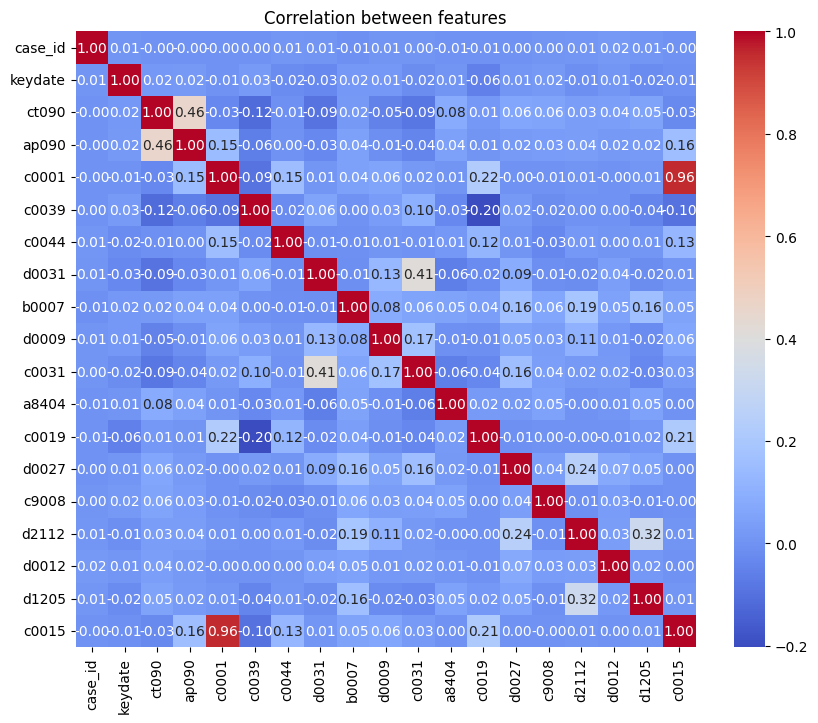

In [11]:
# Check correlations between features
corr = df.corr()
print(corr)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation between features')
plt.show()

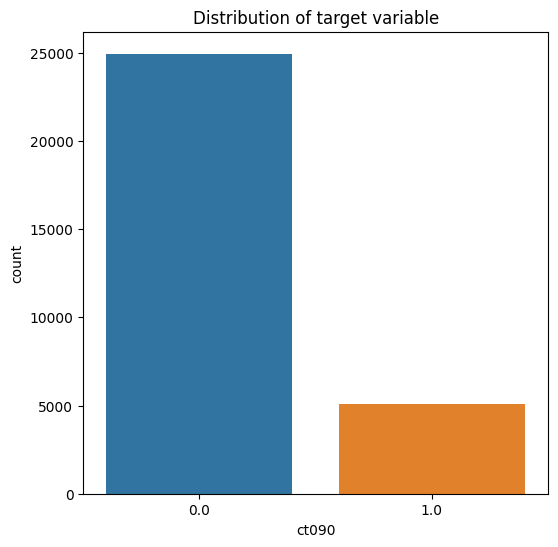

In [12]:
# Distribution of the target variable
plt.figure(figsize=(6, 6))
sns.countplot(x='ct090', data=df)
plt.title('Distribution of target variable')
plt.show()

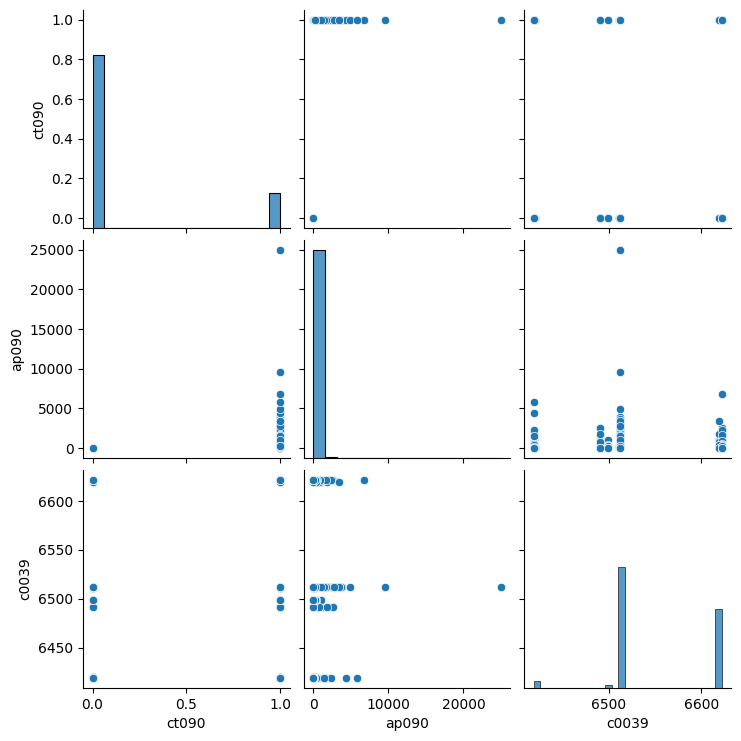

In [13]:
# Pairplot
sns.pairplot(df[['ct090', 'ap090', 'c0039']])
plt.show()

Conclusions
- the dataset contains 30,000 observations and 289 features.
- There are missing values in some of the features.
- The target variable 'ct090' is a binary variable with most of the values being 0, indicating that payment was not made within 90 days.
- There is a moderate positive correlation between ct090 and ap090, indicating that debtors with more overdue loans are more likely to not make payment within 90 days.

### Work with missing values and draw some conclusions

In [14]:
print(df.isnull().sum())

case_id        0
keydate        0
ct090          0
ap090          0
c0001         25
c0039          0
c0044          0
d0031      12629
b0007      16926
d0009          0
c0031          0
a8404      10401
c0019          0
d0027          0
c9008       2984
d2112      16952
d0012          0
d1205      21238
c0015          0
dtype: int64


In [14]:
df.dropna(inplace=True)

In [15]:
df.dropna(axis=1, inplace=True) #drop columns with any missing values

In [16]:
df.fillna(df.mean(), inplace=True)


In [17]:
df.fillna(df.median(), inplace=True)


In [18]:
df.interpolate(inplace=True)


In [114]:
print(df.isnull().sum())

case_id    0
keydate    0
ct090      0
ap090      0
c0001      0
c0039      0
c0044      0
d0031      0
b0007      0
d0009      0
c0031      0
a8404      0
c0019      0
d0027      0
c9008      0
d2112      0
d0012      0
d1205      0
c0015      0
dtype: int64


### Feature engineering

In [15]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

In [16]:
# Split data into target and features
X = df.drop(['ct090', 'case_id', 'keydate'], axis=1) # features
y = df['ct090'] # target

In [17]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [19]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# One-hot encode categorical variables
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train_scaled)
X_test_encoded = encoder.transform(X_test_scaled)

In [21]:
# Fit logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_encoded, y_train)

LogisticRegression(random_state=42)

In [22]:
# Make predictions on test set
y_pred = model.predict(X_test_encoded)
y_proba = model.predict_proba(X_test_encoded)[:, 1]

In [23]:
# Evaluate model performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print('ROC AUC score:', roc_auc_score(y_test, y_proba))

Accuracy: 0.9995
Precision: 0.9990059642147118
Recall: 0.9980139026812314
F1 score: 0.9985096870342772
ROC AUC score: 0.9989297827285907


Text(0.5, 1.0, 'ROC Curve')

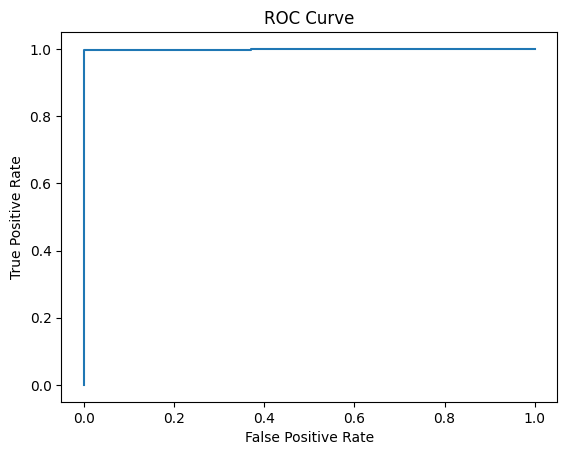

In [24]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

Text(0.5, 1.0, 'Confusion Matrix')

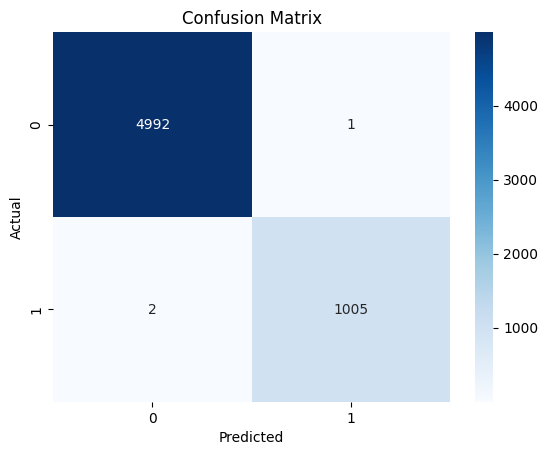

In [25]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

I think this has been overfitted. But could not find where to fix.

### Modeling: solve the problem and compare several models

* Random Forest
* Gradient Boosting
* XGBoost
* LightGMB
* Others

## Random Forest

Accuracy: 0.9996666666666667
Precision: 1.0
Recall: 0.9980139026812314
F1 score: 0.9990059642147118
ROC AUC score: 0.9987414356265604


Text(0.5, 1.0, 'Confusion Matrix')

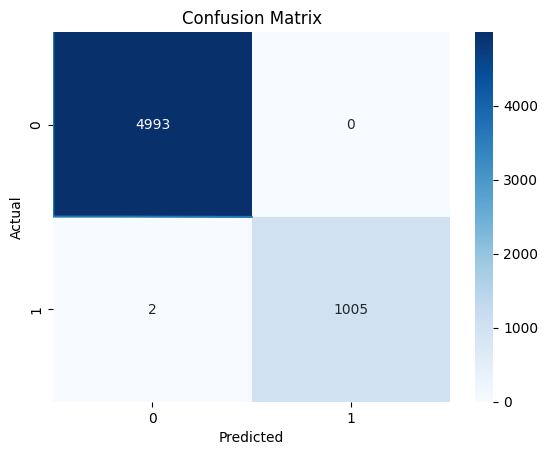

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Fit random forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_imputed, y_train)

# Make predictions on test set
y_pred = model.predict(X_test_imputed)
y_proba = model.predict_proba(X_test_imputed)[:, 1]

# Evaluate model performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print('ROC AUC score:', roc_auc_score(y_test, y_proba))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


## Gradient Boosting

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
# Fit gradient boosting model
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train_imputed, y_train)

# Make predictions on test set
y_pred = model.predict(X_test_imputed)
y_proba = model.predict_proba(X_test_imputed)


Accuracy: 0.9988333333333334
Precision: 0.995049504950495
Recall: 0.9980139026812314
F1 score: 0.9965294992563213
ROC AUC score: 0.9981153356506457


Text(0.5, 1.0, 'Confusion Matrix')

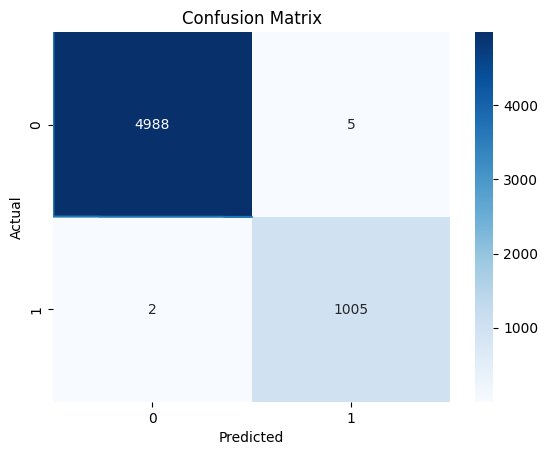

In [28]:
# Make predictions on test set
y_pred = model.predict(X_test_imputed)
y_proba = model.predict_proba(X_test_imputed)[:, 1]

# Evaluate model performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print('ROC AUC score:', roc_auc_score(y_test, y_proba))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')